In [2]:
# import matplotlib.pyplot as plot
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd
import scipy.io
import mat73
import math 
import pickle 
import random 

from scipy.ndimage import gaussian_filter
from scipy import ndimage
# from matplotlib.pyplot import figure


In [3]:
##  GET INDICES OF SPECIFIC TRIALS. WE CAN USE THESE INDICES LATER TO GET POKEIN ETC OF THE TRIALS WE ARE INTERESTED IN 

## use indices during all odor a,b,c,d presentations, and not just trials when all are inseq: 
## select only correct inseq trials:

def get_inseq_odors_local(pretrialbehav):

    x = np.transpose(pretrialbehav['Odor'])
    idx_1 = [i for i in range(0,len(x)) if int(x[i])== 1 ]
    idx_2 = [i for i in range(0,len(x)) if int(x[i])== 2 ]
    idx_3 = [i for i in range(0,len(x)) if int(x[i])== 3 ]
    idx_4 = [i for i in range(0,len(x)) if int(x[i])== 4 ]
    idx_5 = [i for i in range(0,len(x)) if int(x[i])== 5 ]

    all_trials = {}
    key_list = ["1","2","3","4","5"]
    value_list = [idx_1,idx_2,idx_3,idx_4,idx_5]

    #get pairs of elements: 
    zip_iterator = zip(key_list,value_list)
    all_trials = dict(zip_iterator)

    import math 

    for k,v in all_trials.items():
        idx = all_trials[k]
        x = np.transpose(pretrialbehav['Performance'])
        selected_performance = x[idx]
        x = np.transpose(pretrialbehav['PokeDuration']) 
        selected_durations = x[idx]
        x = np.transpose(pretrialbehav['Position'])
        selected_positions = x[idx]
        for i in range(len(idx)-1):
        # for inseq odors, check for timming erros and don't mark them as incorrect 
            if selected_performance[i] == 0 and selected_positions[i] == int(k) and selected_durations[i] > 1.05 :
                idx[i] = idx[i]
            elif selected_performance[i] == 1 and selected_positions[i] == int(k):
                idx[i] = idx[i]
            else: 
                idx[i] = np.nan 

    #     print(idx)
        idx_sel = [i for i in idx if math.isnan(i) == False]
        all_trials[k] = idx_sel
        
    # get POKEIN indices 
    x = np.transpose(pretrialbehav['PokeInIndex'])
    pokein_o0 = x[all_trials['1']]
    pokein_o1 = x[all_trials['2']]
    pokein_o2 = x[all_trials['3']]
    pokein_o3 = x[all_trials['4']]
    pokein_o4 = x[all_trials['5']]

    pokein = np.concatenate([pokein_o0,pokein_o1,pokein_o2,pokein_o3,pokein_o4])

    key_list = ['1','2','3','4','5']
    value_list = [pokein_o0,pokein_o1,pokein_o2,pokein_o3,pokein_o4]
    zip_iterator = zip(key_list,value_list)
    pokein_dict = dict(zip_iterator)

    print(pokein_o0.shape)
    print(pokein_o1.shape)
    print(pokein_o2.shape)
    print(pokein_o3.shape)
    print(pokein_o4.shape)
    print(pokein.shape)


    # get pokeout 
    x = np.transpose(pretrialbehav['PokeOutIndex'])
    pokeout_o0 = x[all_trials['1']]
    pokeout_o1 = x[all_trials['2']]
    pokeout_o2 = x[all_trials['3']]
    pokeout_o3 = x[all_trials['4']]
    pokeout_o4 = x[all_trials['5']]

    pokeout = np.concatenate([pokeout_o0,pokeout_o1,pokeout_o2,pokeout_o3,pokeout_o4])

        
    return (all_trials,pokein_o0, pokein_o1,pokein_o2, pokein_o3, pokein_o4, pokeout_o0, pokeout_o1, pokeout_o2, pokeout_o3, pokeout_o4)
  

In [4]:

## DEFINE FUNCTION TO GET 2 CONSECUTIVE INSEQ ODORS: 

def get_inseq_odor_E(pretrialbehav, odor_int):
    
    x = np.transpose(pretrialbehav['Odor'])
    
    if odor_int == 5:
        odor_int_next = 1
    else: 
        odor_int_next = odor_int + 1

    sublist= [odor_int,odor_int_next] #[1, 2, 3, 4]

    inseq = [i for i in range(0,len(x)) if list(x[i:i+len(sublist)])==sublist]
    #print(inseq)

    x = np.transpose(pretrialbehav['Position'])
    #to recheck:
    pos = [i for i in range(0,len(x)) if list(x[i:i+len(sublist)])==sublist]
    #print(pos)
    print('check if this is 0: ',len(np.intersect1d(inseq,pos)) - len(inseq))

    return inseq; 



In [14]:
# function to convolve spikes over a gaussian . Here I specify the start index, and then the length  : 
def get_gaussian_spikes_length(sigma,spiking, start_time,length):
    # convolve spikes over a gaussian : 
    spikes_gaussian = {} 
    for trial in range(len(start_time)):
        spikes = spiking[start_time[trial][0][0][0]:start_time[trial][0][0][0]+length,1:spiking.shape[1]]
        spikes_gaussian_indiv = np.zeros([spikes.shape[0],spikes.shape[1]])
        for neuron in range(spikes.shape[1]):
            spikes_gaussian_indiv[:,neuron] = gaussian_filter(spikes[:,neuron],sigma)/np.max(gaussian_filter(spikes[:,neuron],sigma))

        spikes_gaussian[trial] = spikes_gaussian_indiv
        
    return(spikes_gaussian)
    

In [6]:
# function to convolve spikes over a gaussian. Here I specify the start index and also the end index : 
def get_gaussian_spikes(sigma,spiking,end_time, start_time):
    # convolve spikes over a gaussian : 
    spikes_gaussian = {} 
    for trial in range(len(pokein_first_odor)):
        spikes = spiking[start_time[trial][0][0][0]:end_time[trial][0][0][0],1:spiking.shape[1]]
        spikes_gaussian_indiv = np.zeros([spikes.shape[0],spikes.shape[1]])
        for neuron in range(spikes.shape[1]):
            spikes_gaussian_indiv[:,neuron] = gaussian_filter(spikes[:,neuron],sigma)/np.max(gaussian_filter(spikes[:,neuron],sigma))

        spikes_gaussian[trial] = spikes_gaussian_indiv
        
    return(spikes_gaussian)
    

In [7]:
# sorting function 

def sort_neurons(spikes_gaussian, trial):
    spike_idx_indiv = np.zeros([spikes_gaussian[trial].shape[1]])
    for neuron in range(spikes_gaussian[trial].shape[1]):
        if (np.isnan(np.sum(spikes_gaussian[trial][:,neuron])) == False):
            spike_idx_indiv[neuron] = np.where(spikes_gaussian[trial][:,neuron] ==1)[0][0]
        else :
            spike_idx_indiv[neuron] = np.nan

#     np.sort(spike_idx_indiv)
    
    return(np.argsort(spike_idx_indiv),spikes_gaussian[trial][:,np.argsort(spike_idx_indiv)])
    
    

In [8]:
# sorting function - to the max

def sort_neurons_mean(spikes_gaussian_mean):
    spike_idx_indiv = np.zeros([spikes_gaussian_mean.shape[1]])
    for neuron in range(spikes_gaussian_mean.shape[1]):
        if (np.isnan(np.sum(spikes_gaussian_mean[:,neuron])) == False):
            spike_idx_indiv[neuron] = np.where(spikes_gaussian_mean[:,neuron] ==np.max(spikes_gaussian_mean[:,neuron]))[0][0]
        else :
            spike_idx_indiv[neuron] = np.nan

#     np.sort(spike_idx_indiv)
    
    return(np.argsort(spike_idx_indiv),spikes_gaussian_mean[:,np.argsort(spike_idx_indiv)])
    
    

In [138]:
behav_mat = scipy.io.loadmat('Barat_BehaviorMatrix.mat') #Barat_BehaviorMatrix.mat
ensemble_mat = mat73.loadmat('Barat_EnsembleMatrix.mat')
behav_info = scipy.io.loadmat('Barat_preTrialBehavmatrix.mat') #behav_info.mat #Barat_preTrialBehavmatrix

pretrialbehav = behav_info["preTrialBehavMatrix"]
spiking = ensemble_mat["ensembleMatrix"]  #FIRST COLUMN IS THE TIME, THE REST ARE THE ACTIVITIES OF SINGLE UNITS 


In [123]:
behav_mat['behavMatrixColIDs']

array([[array(['TimeBin'], dtype='<U7'), array(['Odor1'], dtype='<U5'),
        array(['Odor2'], dtype='<U5'), array(['Odor3'], dtype='<U5'),
        array(['Odor4'], dtype='<U5'), array(['Odor5'], dtype='<U5'),
        array(['Position1'], dtype='<U9'),
        array(['Position2'], dtype='<U9'),
        array(['Position3'], dtype='<U9'),
        array(['Position4'], dtype='<U9'),
        array(['Position5'], dtype='<U9'),
        array(['InSeqLog'], dtype='<U8'),
        array(['PerformanceLog'], dtype='<U14'),
        array(['PokeEvents'], dtype='<U10'),
        array(['FrontReward'], dtype='<U11'),
        array(['BackReward'], dtype='<U10'),
        array(['XvalRatMazePosition'], dtype='<U19'),
        array(['YvalRatMazePosition'], dtype='<U19')]], dtype=object)

Text(0.5, 1.0, 'acitivity of a neuron during the session')

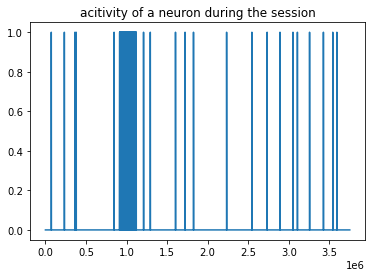

In [133]:
plt.plot(spiking[:,1])
plt.title('acitivity of a neuron during the session')

In [139]:
# get inseq trial indices for poke in and poke out 

(all_trials,pokein_o0, pokein_o1,pokein_o2, pokein_o3, pokein_o4, pokeout_o0, pokeout_o1, pokeout_o2, pokeout_o3, pokeout_o4) = get_inseq_odors_local(pretrialbehav)

pokein = np.concatenate([pokein_o0,pokein_o1,pokein_o2,pokein_o3,pokein_o4])
key_list = ['1','2','3','4','5']
value_list = [pokein_o0,pokein_o1,pokein_o2,pokein_o3,pokein_o4]
zip_iterator = zip(key_list,value_list)
pokein_dict = dict(zip_iterator)

pokeout = np.concatenate([pokeout_o0,pokeout_o1,pokeout_o2,pokeout_o3,pokeout_o4])
key_list = ['1','2','3','4','5']
value_list = [pokeout_o0,pokeout_o1,pokeout_o2,pokeout_o3,pokeout_o4]
zip_iterator = zip(key_list,value_list)
pokeout_dict = dict(zip_iterator)


(48, 1)
(35, 1)
(25, 1)
(26, 1)
(21, 1)
(155, 1)


In [144]:
pokein_dict['2']

array([[array([[154262]])],
       [array([[242877]])],
       [array([[318419]])],
       [array([[396231]])],
       [array([[455930]])],
       [array([[492638]])],
       [array([[537447]])],
       [array([[676256]])],
       [array([[769214]])],
       [array([[861521]])],
       [array([[914666]])],
       [array([[961667]])],
       [array([[1080768]])],
       [array([[1218170]])],
       [array([[1323352]])],
       [array([[1442047]])],
       [array([[1579944]])],
       [array([[1633152]])],
       [array([[1730307]])],
       [array([[1769940]])],
       [array([[1841819]])],
       [array([[1954708]])],
       [array([[2040261]])],
       [array([[2284907]])],
       [array([[2510176]])],
       [array([[2698252]])],
       [array([[2779785]])],
       [array([[2821748]])],
       [array([[2853725]])],
       [array([[2904933]])],
       [array([[2952249]])],
       [array([[3133102]])],
       [array([[3419682]])],
       [array([[3563139]])],
       [array([[3568238]])

In [146]:
sigma = 150 
length = 1200
# end_time = pokeout_o0 #pokein_second_odor

start_time = pokein_o0 #pokein_first_odor
spikes_gaussian_a = get_gaussian_spikes_length(sigma,spiking, start_time,length)

##
start_time = pokein_o1 #pokein_first_odor
spikes_gaussian_b = get_gaussian_spikes_length(sigma,spiking, start_time,length)

##
start_time = pokein_o2 #pokein_first_odor
spikes_gaussian_c = get_gaussian_spikes_length(sigma,spiking, start_time,length)

##
start_time = pokein_o3 #pokein_first_odor
spikes_gaussian_d = get_gaussian_spikes_length(sigma,spiking, start_time,length)

##
start_time = pokein_o4 #pokein_first_odor
spikes_gaussian_e = get_gaussian_spikes_length(sigma,spiking, start_time,length)



C:\Users\FORTIN~1\AppData\Local\Temp/ipykernel_4200/3351525590.py:9: RuntimeWarning: invalid value encountered in true_divide
  spikes_gaussian_indiv[:,neuron] = gaussian_filter(spikes[:,neuron],sigma)/np.max(gaussian_filter(spikes[:,neuron],sigma))


Text(0.5, 1.0, 'actiivty of a neuron after - gaussian kernel smoothing')

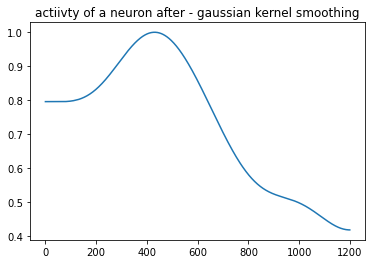

In [149]:
plt.plot(spikes_gaussian_a[0][:,1])
plt.title('actiivty of a neuron after - gaussian kernel smoothing')

In [147]:
# get the avg activity during all odor a trials : 
avg_gaussian_a = get_avg_spiking(spikes_gaussian_a_rat1)

(0.0, 5.0)

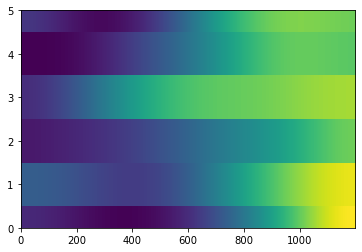

In [151]:
# plot PSTH

[sort_idx , sorted_gaussian] = sort_neurons_mean(avg_gaussian_a) 
plt.imshow(np.flip(sorted_gaussian.T,1), cmap='viridis', interpolation='nearest', aspect='auto')
plt.ylim([0,5])